In [ ]:
# https://github.com/aarshayj/Analytics_Vidhya/blob/master/Articles/Parameter_Tuning_XGBoost_with_Example/XGBoost%20models.ipynb

In [10]:
import numpy as np
import pandas as pd

import pandas.core.algorithms as algos
from pandas import Series
import scipy.stats.stats as stats
import re
import traceback
import string

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

In [2]:
train = pd.read_csv("data/CAX_MortgageModeling_Train.csv")
test = pd.read_csv("data/CAX_MortgageModeling_Test.csv")

In [6]:
train.shape

(45642, 22)

In [7]:
train.head()

,Unique_ID,MORTGAGE NUMBER,PROPERTY VALUE,MORTGAGE PAYMENT,GDS,LTV,TDS,AMORTIZATION,MORTGAGE AMOUNT,RATE,...,PROPERTY TYPE,TERM,FSA,AGE RANGE,GENDER,INCOME,INCOME TYPE,NAICS CODE,CREDIT SCORE,RESULT
0,CAX_Train_1,1,900000,5429,61.98,65.00,71.63,360,1040000.0,4.0,...,Single Detached,12,L4C,Under 25,Male,108000,8,44-45,681,FUNDED
1,CAX_Train_2,2,386000,2179,35.22,74.29,40.65,360,390000.0,4.5,...,Single Detached,12,L9T,70 and over,Male,78000,2,56,710,FUNDED
2,CAX_Train_3,3,531000,2152,30.97,80.00,35.41,360,424800.0,3.5,...,Single Detached,6,M1N,35-39,Female,87000,2,72,709,FUNDED
3,CAX_Train_4,4,1200000,5410,19.04,75.00,34.14,360,960000.0,5.5,...,Single Detached,12,M2M,45-49,Male,300000,8,54,761,FUNDED
4,CAX_Train_5,5,350000,3342,29.59,80.00,34.85,360,592000.0,5.0,...,Single Detached,12,L7G,50-54,Male,147000,8,62,762,FUNDED


In [8]:
train.RESULT.value_counts()

FUNDED        36023
NOT FUNDED     9619
Name: RESULT, dtype: int64

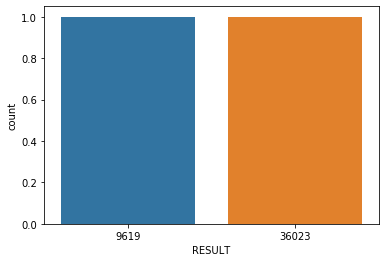

In [11]:
ax = sns.countplot(x=train.RESULT.value_counts())

In [12]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45642 entries, 0 to 45641
Data columns (total 22 columns):
Unique_ID            45642 non-null object
MORTGAGE NUMBER      45642 non-null int64
PROPERTY VALUE       45642 non-null int64
MORTGAGE PAYMENT     45642 non-null int64
GDS                  45642 non-null float64
LTV                  45642 non-null float64
TDS                  45642 non-null float64
AMORTIZATION         45642 non-null int64
MORTGAGE AMOUNT      45642 non-null float64
RATE                 45642 non-null float64
MORTGAGE PURPOSE     45642 non-null object
PAYMENT FREQUENCY    45642 non-null object
PROPERTY TYPE        45642 non-null object
TERM                 45642 non-null int64
FSA                  45642 non-null object
AGE RANGE            45642 non-null object
GENDER               45642 non-null object
INCOME               45642 non-null int64
INCOME TYPE          45642 non-null int64
NAICS CODE           45642 non-null object
CREDIT SCORE         45642 non-nu

### check missing values

In [16]:
train_missing = train.isna()
train_num_missing = train_missing.sum()
train_num_missing / len(train)

Unique_ID            0.0
MORTGAGE NUMBER      0.0
PROPERTY VALUE       0.0
MORTGAGE PAYMENT     0.0
GDS                  0.0
LTV                  0.0
TDS                  0.0
AMORTIZATION         0.0
MORTGAGE AMOUNT      0.0
RATE                 0.0
MORTGAGE PURPOSE     0.0
PAYMENT FREQUENCY    0.0
PROPERTY TYPE        0.0
TERM                 0.0
FSA                  0.0
AGE RANGE            0.0
GENDER               0.0
INCOME               0.0
INCOME TYPE          0.0
NAICS CODE           0.0
CREDIT SCORE         0.0
RESULT               0.0
dtype: float64

In [17]:
data_types = pd.DataFrame(train.dtypes, columns=['type'])
data_types['Feature'] = data_types.index
data_types.type.unique()

array([dtype('O'), dtype('int64'), dtype('float64')], dtype=object)

In [19]:
cols_to_drop = ['Unique_ID', 'RESULT', 'FSA']
df_funded = train[train.RESULT == 'FUNDED']
df_not_funded = train[train.RESULT == 'NOT FUNDED']

In [20]:
def plot_hist_object(funded, not_funded, col):
    fig= plt.figure(figsize=(12,5))
    legend = ['Funded', 'Not Funded']
    plt.hist([funded, not_funded], color=['red', 'blue'])
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.legend(legend)
    plt.show()
    
def plot_hist(funded, not_funded, col):
    legend = ['Funded', 'Not Funded']
    plt.hist([funded, not_funded], color=['red', 'blue'])
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.legend(legend)
    plt.xticks(range(0, 7))
    plt.yticks(range(1, 20))
    plt.show()

In [21]:
#for i,row in data_types.iterrows():
#    if row.Feature not in cols_to_drop:
#        col = row.Feature
#        funded = df_funded[col]
#        not_funded = df_not_funded[col]
#        if row.type == "object":
#            plot_hist_object(funded, not_funded, col)
            

## WOE and IV

In [22]:
# import packages
import pandas as pd
import numpy as np
import pandas.core.algorithms as algos
from pandas import Series
import scipy.stats.stats as stats
import re
import traceback
import string

max_bin = 20
force_bin = 3

# define a binning function
def mono_bin(Y, X, n = max_bin):
    
    df1 = pd.DataFrame({"X": X, "Y": Y})
    justmiss = df1[['X','Y']][df1.X.isnull()]
    notmiss = df1[['X','Y']][df1.X.notnull()]
    r = 0
    while np.abs(r) < 1:
        try:
            d1 = pd.DataFrame({"X": notmiss.X, "Y": notmiss.Y, "Bucket": pd.qcut(notmiss.X, n)})
            d2 = d1.groupby('Bucket', as_index=True)
            r, p = stats.spearmanr(d2.mean().X, d2.mean().Y)
            n = n - 1 
        except Exception as e:
            n = n - 1

    if len(d2) == 1:
        n = force_bin         
        bins = algos.quantile(notmiss.X, np.linspace(0, 1, n))
        if len(np.unique(bins)) == 2:
            bins = np.insert(bins, 0, 1)
            bins[1] = bins[1]-(bins[1]/2)
        d1 = pd.DataFrame({"X": notmiss.X, "Y": notmiss.Y, "Bucket": pd.cut(notmiss.X, np.unique(bins),include_lowest=True)}) 
        d2 = d1.groupby('Bucket', as_index=True)
    
    d3 = pd.DataFrame({},index=[])
    d3["MIN_VALUE"] = d2.min().X
    d3["MAX_VALUE"] = d2.max().X
    d3["COUNT"] = d2.count().Y
    d3["EVENT"] = d2.sum().Y
    d3["NONEVENT"] = d2.count().Y - d2.sum().Y
    d3=d3.reset_index(drop=True)
    
    if len(justmiss.index) > 0:
        d4 = pd.DataFrame({'MIN_VALUE':np.nan},index=[0])
        d4["MAX_VALUE"] = np.nan
        d4["COUNT"] = justmiss.count().Y
        d4["EVENT"] = justmiss.sum().Y
        d4["NONEVENT"] = justmiss.count().Y - justmiss.sum().Y
        d3 = d3.append(d4,ignore_index=True)
    
    d3["EVENT_RATE"] = d3.EVENT/d3.COUNT
    d3["NON_EVENT_RATE"] = d3.NONEVENT/d3.COUNT
    d3["DIST_EVENT"] = d3.EVENT/d3.sum().EVENT
    d3["DIST_NON_EVENT"] = d3.NONEVENT/d3.sum().NONEVENT
    d3["WOE"] = np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["IV"] = (d3.DIST_EVENT-d3.DIST_NON_EVENT)*np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["VAR_NAME"] = "VAR"
    d3 = d3[['VAR_NAME','MIN_VALUE', 'MAX_VALUE', 'COUNT', 'EVENT', 'EVENT_RATE', 'NONEVENT', 'NON_EVENT_RATE', 'DIST_EVENT','DIST_NON_EVENT','WOE', 'IV']]       
    d3 = d3.replace([np.inf, -np.inf], 0)
    d3.IV = d3.IV.sum()
    
    return(d3)

def char_bin(Y, X):
        
    df1 = pd.DataFrame({"X": X, "Y": Y})
    justmiss = df1[['X','Y']][df1.X.isnull()]
    notmiss = df1[['X','Y']][df1.X.notnull()]    
    df2 = notmiss.groupby('X',as_index=True)
    
    d3 = pd.DataFrame({},index=[])
    d3["COUNT"] = df2.count().Y
    d3["MIN_VALUE"] = df2.sum().Y.index
    d3["MAX_VALUE"] = d3["MIN_VALUE"]
    d3["EVENT"] = df2.sum().Y
    d3["NONEVENT"] = df2.count().Y - df2.sum().Y
    
    if len(justmiss.index) > 0:
        d4 = pd.DataFrame({'MIN_VALUE':np.nan},index=[0])
        d4["MAX_VALUE"] = np.nan
        d4["COUNT"] = justmiss.count().Y
        d4["EVENT"] = justmiss.sum().Y
        d4["NONEVENT"] = justmiss.count().Y - justmiss.sum().Y
        d3 = d3.append(d4,ignore_index=True)
    
    d3["EVENT_RATE"] = d3.EVENT/d3.COUNT
    d3["NON_EVENT_RATE"] = d3.NONEVENT/d3.COUNT
    d3["DIST_EVENT"] = d3.EVENT/d3.sum().EVENT
    d3["DIST_NON_EVENT"] = d3.NONEVENT/d3.sum().NONEVENT
    d3["WOE"] = np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["IV"] = (d3.DIST_EVENT-d3.DIST_NON_EVENT)*np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["VAR_NAME"] = "VAR"
    d3 = d3[['VAR_NAME','MIN_VALUE', 'MAX_VALUE', 'COUNT', 'EVENT', 'EVENT_RATE', 'NONEVENT', 'NON_EVENT_RATE', 'DIST_EVENT','DIST_NON_EVENT','WOE', 'IV']]      
    d3 = d3.replace([np.inf, -np.inf], 0)
    d3.IV = d3.IV.sum()
    d3 = d3.reset_index(drop=True)
    
    return(d3)

def data_vars(df1, target):
    
    stack = traceback.extract_stack()
    filename, lineno, function_name, code = stack[-2]
    vars_name = re.compile(r'\((.*?)\).*$').search(code).groups()[0]
    final = (re.findall(r"[\w']+", vars_name))[-1]
    
    x = df1.dtypes.index
    count = -1
    
    for i in x:
        if i.upper() not in (final.upper()):
            if np.issubdtype(df1[i], np.number) and len(Series.unique(df1[i])) > 2:
                conv = mono_bin(target, df1[i])
                conv["VAR_NAME"] = i
                count = count + 1
            else:
                conv = char_bin(target, df1[i])
                conv["VAR_NAME"] = i            
                count = count + 1
                
            if count == 0:
                iv_df = conv
            else:
                iv_df = iv_df.append(conv,ignore_index=True)
    
    iv = pd.DataFrame({'IV':iv_df.groupby('VAR_NAME').IV.max()})
    iv = iv.reset_index()
    return(iv_df,iv) 

In [23]:
df = train
df['target'] = df['RESULT'].apply(lambda x : 1 if x == 'FUNDED' else 0)  # Convert to numeric
df = df.drop(['Unique_ID', 'RESULT', 'MORTGAGE NUMBER'],axis=1)

In [24]:
from sklearn.model_selection import train_test_split
y = train['target']
X = df.drop(['target'],axis=1)
x_train, x_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.10, random_state = 20)

In [25]:
final_iv, IV = data_vars(x_train, y_train)

In [26]:
IV.sort_values('IV')

,VAR_NAME,IV
7,INCOME TYPE,0.000004
2,CREDIT SCORE,0.000322
4,GDS,0.000486
1,AMORTIZATION,0.000701
17,TDS,0.002831
5,GENDER,0.003137
6,INCOME,0.003495
0,AGE RANGE,0.003552
13,PAYMENT FREQUENCY,0.006673
18,TERM,0.008699


In [27]:
IV.to_csv('IV.csv')

### Apply WOE values to your dataframe columns

In [28]:
transform_vars_list = x_train.columns
transform_prefix = 'new_' # leave this value blank if you need replace the original column values

In [29]:
transform_vars_list

Index(['PROPERTY VALUE', 'MORTGAGE PAYMENT', 'GDS', 'LTV', 'TDS',
       'AMORTIZATION', 'MORTGAGE AMOUNT', 'RATE', 'MORTGAGE PURPOSE',
       'PAYMENT FREQUENCY', 'PROPERTY TYPE', 'TERM', 'FSA', 'AGE RANGE',
       'GENDER', 'INCOME', 'INCOME TYPE', 'NAICS CODE', 'CREDIT SCORE'],
      dtype='object')

In [30]:
def apply_WOE(df, transform_vars_list, final_iv):
    
    for var in transform_vars_list:
        small_df = final_iv[final_iv['VAR_NAME'] == var]
        transform_dict = dict(zip(small_df.MAX_VALUE,small_df.WOE))
        replace_cmd = ''
        replace_cmd1 = ''
        for i in sorted(transform_dict.items()):
            replace_cmd = replace_cmd + str(i[1]) + str(' if x <= ') + str(i[0]) + ' else '
            replace_cmd1 = replace_cmd1 + str(i[1]) + str(' if x == "') + str(i[0]) + '" else '
        replace_cmd = replace_cmd + '0'
        replace_cmd1 = replace_cmd1 + '0'
        if replace_cmd != '0':
            try:
                df[transform_prefix + var] = df[var].apply(lambda x: eval(replace_cmd))
            except:
                df[transform_prefix + var] = df[var].apply(lambda x: eval(replace_cmd1))
                
    return df

In [31]:
#x_train_new = apply_WOE(x_train, transform_vars_list, final_iv)
#x_test_new = apply_WOE(x_test, transform_vars_list, final_iv)

In [32]:
for var in transform_vars_list:
    small_df = final_iv[final_iv['VAR_NAME'] == var]
    transform_dict = dict(zip(small_df.MAX_VALUE,small_df.WOE))
    replace_cmd = ''
    replace_cmd1 = ''
    for i in sorted(transform_dict.items()):
        replace_cmd = replace_cmd + str(i[1]) + str(' if x <= ') + str(i[0]) + ' else '
        replace_cmd1 = replace_cmd1 + str(i[1]) + str(' if x == "') + str(i[0]) + '" else '
    replace_cmd = replace_cmd + '0'
    replace_cmd1 = replace_cmd1 + '0'
    if replace_cmd != '0':
        try:
            x_train[transform_prefix + var] = x_train[var].apply(lambda x: eval(replace_cmd))
        except:
            x_train[transform_prefix + var] = x_train[var].apply(lambda x: eval(replace_cmd1))

In [33]:
for var in transform_vars_list:
    small_df = final_iv[final_iv['VAR_NAME'] == var]
    transform_dict = dict(zip(small_df.MAX_VALUE,small_df.WOE))
    replace_cmd = ''
    replace_cmd1 = ''
    for i in sorted(transform_dict.items()):
        replace_cmd = replace_cmd + str(i[1]) + str(' if x <= ') + str(i[0]) + ' else '
        replace_cmd1 = replace_cmd1 + str(i[1]) + str(' if x == "') + str(i[0]) + '" else '
    replace_cmd = replace_cmd + '0'
    replace_cmd1 = replace_cmd1 + '0'
    if replace_cmd != '0':
        try:
            x_test[transform_prefix + var] = x_test[var].apply(lambda x: eval(replace_cmd))
        except:
            x_test[transform_prefix + var] = x_test[var].apply(lambda x: eval(replace_cmd1))

In [35]:
import pandas as pd
import numpy as np
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn import  metrics
from sklearn.model_selection import GridSearchCV

import matplotlib.pylab as plt
%matplotlib inline

from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4

In [36]:
def modelfit(alg, dtrain, ytrain, dtest, ytest, predictors,useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=ytrain.values)
        xgtest = xgb.DMatrix(dtest[predictors].values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='auc', early_stopping_rounds=early_stopping_rounds)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], ytrain, eval_metric='auc')
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
        
    #Print model report:
    print("\nModel Report")
    print("Accuracy : %.4g" % metrics.accuracy_score(ytrain.values, dtrain_predictions))
    print("AUC Score (Train): %f" % metrics.roc_auc_score(ytrain, dtrain_predprob))
    
    #Predict on testing data:
    predprob = alg.predict_proba(dtest[predictors])[:,1]
    print('AUC Score (Test): %f' % metrics.roc_auc_score(ytest, predprob))
                
    feat_imp = pd.Series(alg.booster().get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')

### Step 1- Find the number of estimators for a high learning rate

In [37]:
predictors = [x for x in train.columns if "new" in x]

xgb1 = XGBClassifier(
        learning_rate =0.1,
        n_estimators=1000,
        max_depth=5,
        min_child_weight=1,
        gamma=0,
        subsample=0.8,
        colsample_bytree=0.8,
        objective= 'binary:logistic',
        nthread=4,
        scale_pos_weight=1,
        seed=27)

modelfit(xgb1, x_train, y_train, x_test, y_test, predictors)

XGBoostError: [19:55:38] src/learner.cc:723: Check failed: mparam_.num_feature != 0 (0 vs. 0) : 0 feature is supplied.  Are you using raw Booster interface?

In [ ]:
#Grid seach on subsample and max_features
#Choose all predictors except target & IDcols
param_test1 = {
    'max_depth':range(3,10,2),
    'min_child_weight':range(1,6,2)
}
gsearch1 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=5,
                                        min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
                                        objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
                       param_grid = param_test1, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch1.fit(train[predictors],train[target])

In [ ]:
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

In [ ]:
#Grid seach on subsample and max_features
#Choose all predictors except target & IDcols
param_test2 = {
    'max_depth':[4,5,6],
    'min_child_weight':[4,5,6]
}
gsearch2 = GridSearchCV(estimator = XGBClassifier( learning_rate=0.1, n_estimators=140, max_depth=5,
                                        min_child_weight=2, gamma=0, subsample=0.8, colsample_bytree=0.8,
                                        objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
                       param_grid = param_test2, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch2.fit(train[predictors],train[target])

In [ ]:
gsearch2.grid_scores_, gsearch2.best_params_, gsearch2.best_score_

In [ ]:
#Grid seach on subsample and max_features
#Choose all predictors except target & IDcols
param_test2b = {
    'min_child_weight':[6,8,10,12]
}
gsearch2b = GridSearchCV(estimator = XGBClassifier( learning_rate=0.1, n_estimators=140, max_depth=4,
                                        min_child_weight=2, gamma=0, subsample=0.8, colsample_bytree=0.8,
                                        objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
                       param_grid = param_test2b, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch2b.fit(train[predictors],train[target])

In [ ]:
gsearch2b.grid_scores_, gsearch2b.best_params_, gsearch2b.best_score_

In [ ]:
#Grid seach on subsample and max_features
#Choose all predictors except target & IDcols
param_test3 = {
    'gamma':[i/10.0 for i in range(0,5)]
}
gsearch3 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=4,
                                        min_child_weight=6, gamma=0, subsample=0.8, colsample_bytree=0.8,
                                        objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
                       param_grid = param_test3, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch3.fit(train[predictors],train[target])

In [ ]:
gsearch3.grid_scores_, gsearch3.best_params_, gsearch3.best_score_

In [ ]:
xgb2 = XGBClassifier(
        learning_rate =0.1,
        n_estimators=1000,
        max_depth=4,
        min_child_weight=6,
        gamma=0,
        subsample=0.8,
        colsample_bytree=0.8,
        objective= 'binary:logistic',
        nthread=4,
        scale_pos_weight=1,
        seed=27)
modelfit(xgb2, x_train, y_train, x_test, y_test, predictors)

#### Tune subsample and colsample_bytree

In [ ]:

#Grid seach on subsample and max_features
#Choose all predictors except target & IDcols
param_test4 = {
    'subsample':[i/10.0 for i in range(6,10)],
    'colsample_bytree':[i/10.0 for i in range(6,10)]
}
gsearch4 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=177, max_depth=4,
                                        min_child_weight=6, gamma=0, subsample=0.8, colsample_bytree=0.8,
                                        objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
                       param_grid = param_test4, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch4.fit(train[predictors],train[target])

In [ ]:
gsearch4.grid_scores_, gsearch4.best_params_, gsearch4.best_score_

tune subsample

In [ ]:
#Grid seach on subsample and max_features
#Choose all predictors except target & IDcols
param_test5 = {
    'subsample':[i/100.0 for i in range(75,90,5)],
    'colsample_bytree':[i/100.0 for i in range(75,90,5)]
}
gsearch5 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=177, max_depth=4,
                                        min_child_weight=6, gamma=0, subsample=0.8, colsample_bytree=0.8,
                                        objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
                       param_grid = param_test5, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch5.fit(train[predictors],train[target])

In [ ]:
gsearch5.grid_scores_, gsearch5.best_params_, gsearch5.best_score_

In [ ]:
#Grid seach on subsample and max_features
#Choose all predictors except target & IDcols
param_test6 = {
    'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
}
gsearch6 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=177, max_depth=4,
                                        min_child_weight=6, gamma=0.1, subsample=0.8, colsample_bytree=0.8,
                                        objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
                       param_grid = param_test6, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch6.fit(train[predictors],train[target])

In [ ]:
gsearch6.grid_scores_, gsearch6.best_params_, gsearch6.best_score_

In [ ]:
#Grid seach on subsample and max_features
#Choose all predictors except target & IDcols
param_test7 = {
    'reg_alpha':[0, 0.001, 0.005, 0.01, 0.05]
}
gsearch7 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=177, max_depth=4,
                                        min_child_weight=6, gamma=0.1, subsample=0.8, colsample_bytree=0.8,
                                        objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
                       param_grid = param_test7, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch7.fit(train[predictors],train[target])

In [ ]:
gsearch7.grid_scores_, gsearch7.best_params_, gsearch7.best_score_

In [ ]:
xgb3 = XGBClassifier(
        learning_rate =0.1,
        n_estimators=1000,
        max_depth=4,
        min_child_weight=6,
        gamma=0,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_alpha=0.005,
        objective= 'binary:logistic',
        nthread=4,
        scale_pos_weight=1,
        seed=27)
modelfit(xgb3, x_train, y_train, x_test, y_test, predictors)

In [ ]:
xgb4 = XGBClassifier(
        learning_rate =0.01,
        n_estimators=5000,
        max_depth=4,
        min_child_weight=6,
        gamma=0,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_alpha=0.005,
        objective= 'binary:logistic',
        nthread=4,
        scale_pos_weight=1,
        seed=27)
modelfit(xgb4, x_train, y_train, x_test, y_test, predictors)